In [37]:
import sys

import pandas as pd

from from_root import from_root

sys.path.insert(0, str(from_root("src")))

from read_and_write_docs import read_rds

In [25]:
base_loc = "/Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs"

file_name = "filtered_idiolect_results_by_context.xlsx"

raw_calibrated_file_name = "raw_idiolect_calibrated_results_by_context.xlsx"
calibrated_file_name = "filtered_idiolect_calibrated_results_by_context.xlsx"

In [15]:
def create_catagorical_column(df):
    
    # x-axis transform: NaN -> "None"; else int -> str
    df["max_context_cat"] = df["max_context_tokens"].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # ordered categorical: numeric ascending then "None" last (if present)
    numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
    x_order = [str(v) for v in numeric_levels]
    if (df["max_context_cat"] == "None").any():
        x_order.append("None")

    df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=x_order, ordered=True)
    
    return df

In [16]:
raw_df = pd.read_excel(f"{base_loc}/{file_name}")
raw_df = create_catagorical_column(raw_df)

training = raw_df[raw_df['data_type'] == 'training'].copy()
test = raw_df[raw_df['data_type'] == 'test'].copy()

In [26]:
calibrated_df = pd.read_excel(f"{base_loc}/{calibrated_file_name}")
calibrated_df = create_catagorical_column(calibrated_df)

raw_calibrated_df = pd.read_excel(f"{base_loc}/{raw_calibrated_file_name}")
raw_calibrated_df = create_catagorical_column(raw_calibrated_df)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def _order_max_context_cats(cats):
    """Sort like: 100, 200, ... (numeric ascending), then non-numeric, with None last."""
    def key(x):
        x = str(x)
        if x.lower() == "none":
            return (2, float("inf"))  # force to the end
        try:
            return (0, int(x))        # numeric first, ascending
        except ValueError:
            return (1, x)             # then any other strings
    return sorted(pd.unique([str(c) for c in cats]), key=key)

def facet_balacc_vs_context_by_corpus(
    df,
    *,
    x_col="max_context_tokens",
    y_col="balanced_accuracy",
    facet_col="corpus",
    group_col="min_token_size",
    agg_fn="mean",
    ncols=3,
    sharey=True,
    title=None,
    legend=True,
):
    """
    Facet wrap by corpus (one subplot per corpus).
    X: max_context_tokens (as categorical: "None", "100", "200", ...)
    Y: balanced_accuracy
    Lines: min_token_size
    """
    d = df.copy()

    # Build x categorical labels from x_col
    if x_col not in d.columns:
        raise ValueError(f"Missing '{x_col}' in df.")
    d["max_context_tokens_cat"] = d[x_col].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # Check required cols
    for col in [y_col, facet_col, group_col]:
        if col not in d.columns:
            raise ValueError(f"Missing '{col}' in df.")

    # Aggregate in case multiple rows per (corpus, min_token_size, x)
    grp = d.groupby([facet_col, group_col, "max_context_tokens_cat"], dropna=False)[y_col]
    if agg_fn == "mean":
        plot_df = grp.mean().reset_index()
    elif agg_fn == "median":
        plot_df = grp.median().reset_index()
    else:
        raise ValueError("agg_fn must be 'mean' or 'median'")

    # Global ordered x-axis across all facets
    x_order = _order_max_context_cats(plot_df["max_context_tokens_cat"])
    x_pos = np.arange(len(x_order))
    x_index = {lab: i for i, lab in enumerate(x_order)}

    # Facets = corpora
    facet_vals = sorted(plot_df[facet_col].dropna().unique())
    n = len(facet_vals)
    nrows = ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.8 * ncols, 3.6 * nrows),
        sharex=True,
        sharey=sharey,
    )
    axes = np.array(axes).reshape(-1)

    # For a single shared legend
    legend_handles = None
    legend_labels = None

    for i, fac in enumerate(facet_vals):
        ax = axes[i]
        sub_fac = plot_df[plot_df[facet_col] == fac]

        for g in sorted(sub_fac[group_col].dropna().unique()):
            sub_g = sub_fac[sub_fac[group_col] == g]

            y = np.full(len(x_order), np.nan, dtype=float)
            for _, r in sub_g.iterrows():
                y[x_index[r["max_context_tokens_cat"]]] = float(r[y_col])

            ax.plot(x_pos, y, marker="o", linewidth=2, label=f"{group_col}={g}")

        ax.set_title(str(fac))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(y_col)

        if legend and legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # X ticks/labels
    for ax in axes[:n]:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_order)

    # X label only on bottom row
    for ax in axes[(nrows - 1) * ncols : nrows * ncols]:
        if ax.has_data():
            ax.set_xlabel("max_context_tokens")

    # Shared legend (recommended, otherwise every subplot gets messy)
    if legend and legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.02),
            ncol=min(len(legend_labels), 6),
            frameon=False,
        )

    if title:
        fig.suptitle(title, y=1.08 if legend else 1.02)

    plt.tight_layout()
    return fig, axes[:n]

# Example:
# fig, axes = facet_balacc_vs_context_by_corpus(score_df, ncols=3, agg_fn="mean",
#                                               title="Balanced accuracy vs context (faceted by corpus)")
# plt.show()


<positron-console-cell-19>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


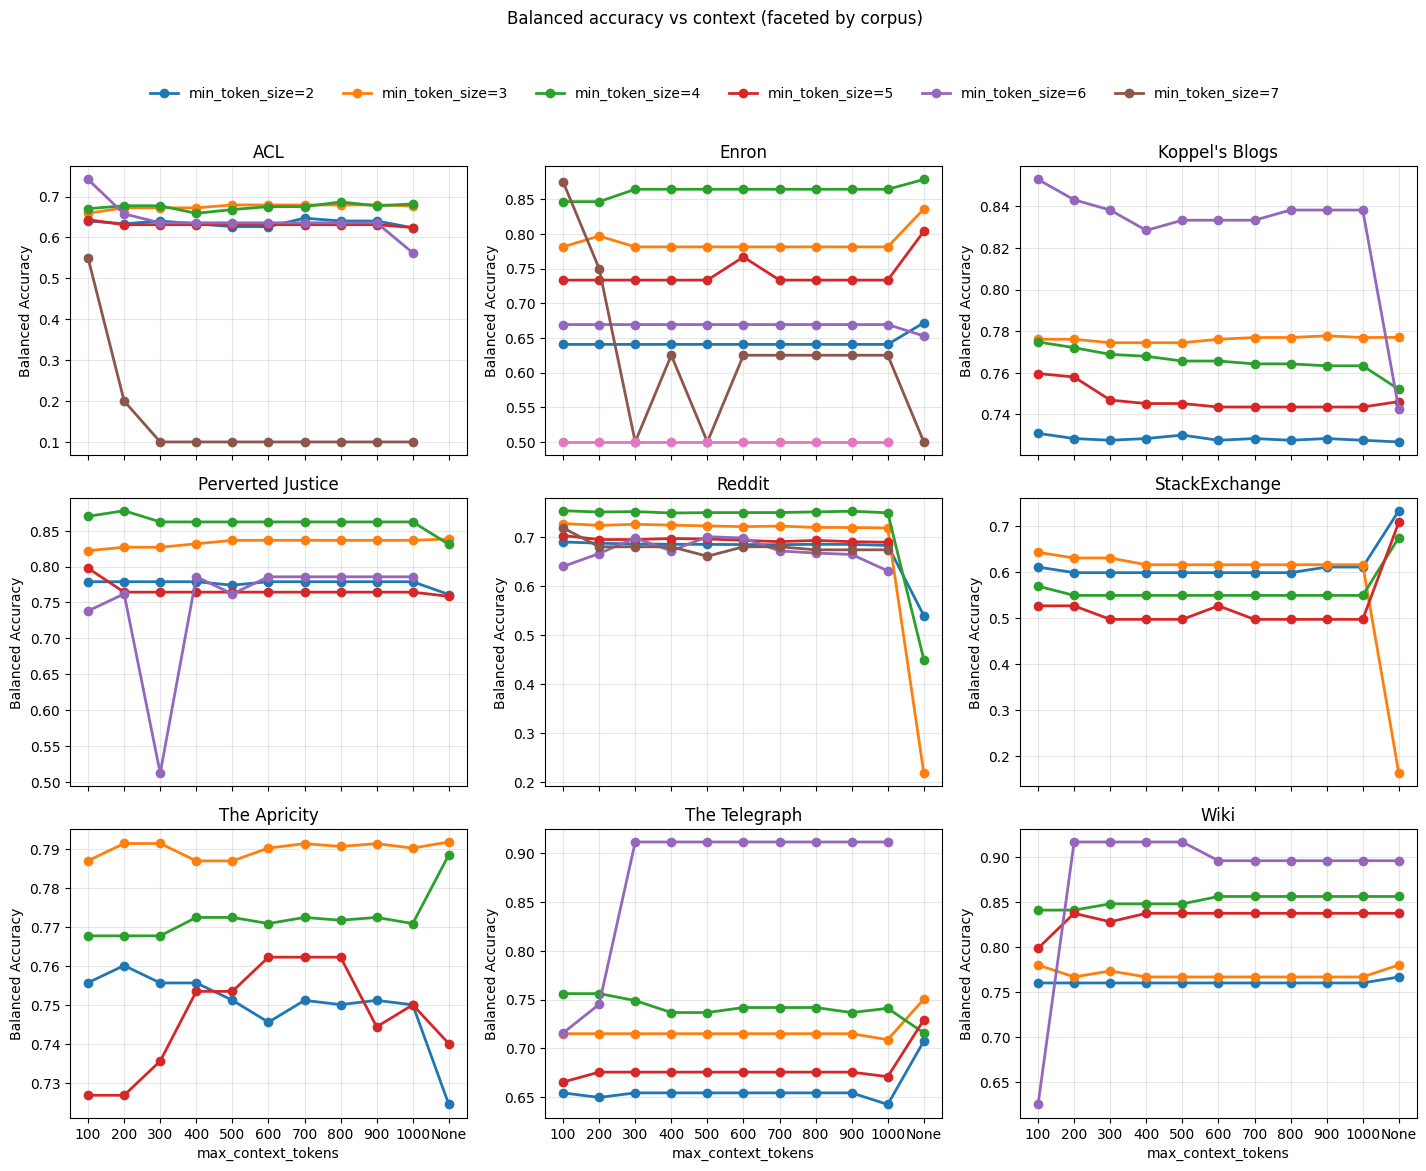

In [19]:
fig, axes = facet_balacc_vs_context_by_corpus(training, ncols=3, agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus)",
                                              sharey=False)
plt.show()

<positron-console-cell-20>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


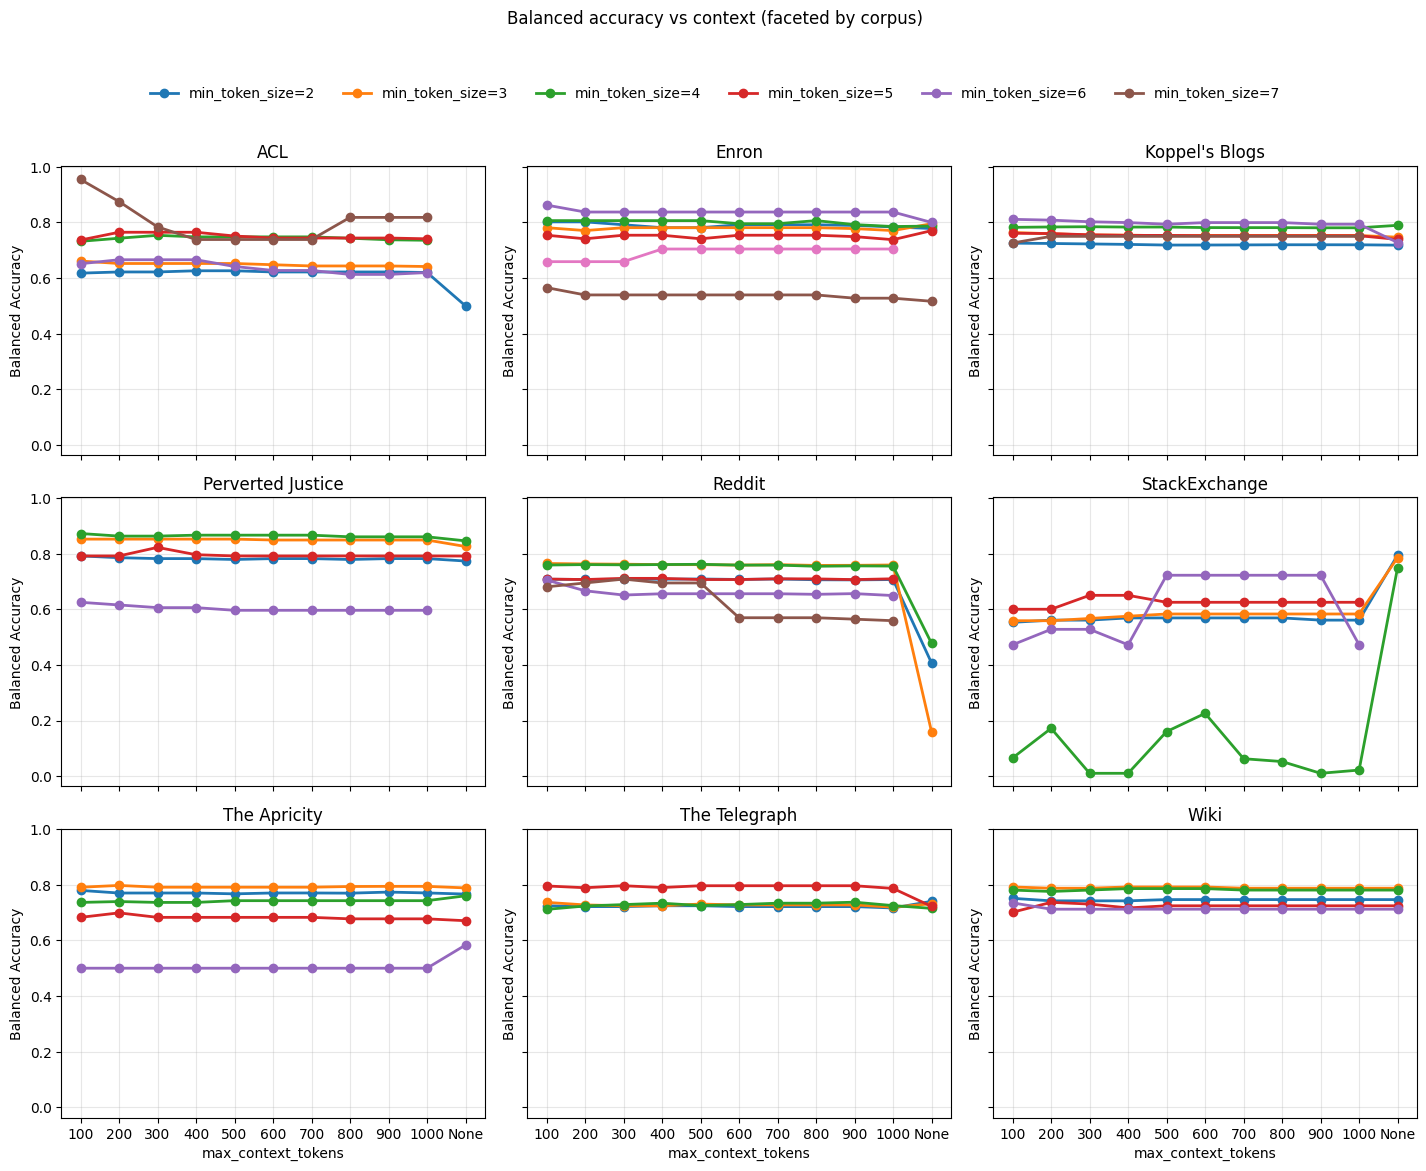

In [20]:
fig, axes = facet_balacc_vs_context_by_corpus(test, ncols=3, agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus)",
                                              sharey=True)
plt.show()

<positron-console-cell-55>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


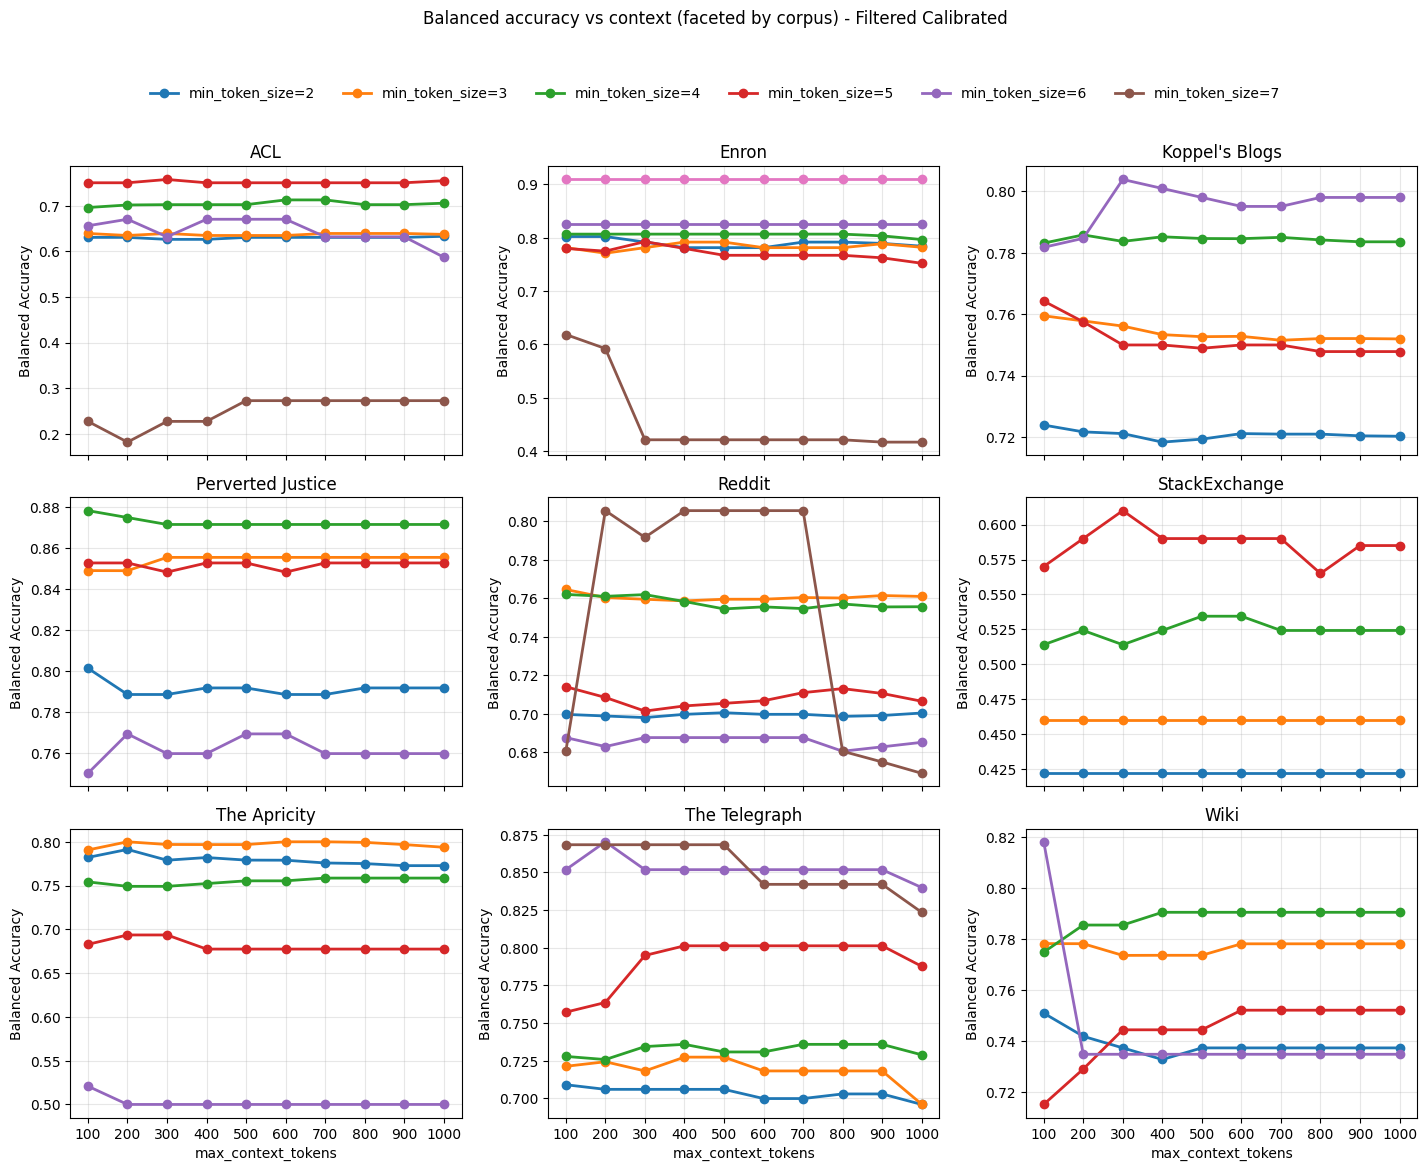

In [55]:
fig, axes = facet_balacc_vs_context_by_corpus(calibrated_df[calibrated_df['max_context_cat'] != "None"],
                                              ncols=3,
                                              agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus) - Filtered Calibrated",
                                              sharey=False)
plt.show()

## Compare filterd to raw

In [33]:
join_cols = ['data_type', 'corpus', 'scoring_model', 'max_context_tokens', 'min_token_size']

# If yours are titled like "Cllr", "AUC", "Balanced Accuracy", use:
metrics = ["Cllr", "AUC", "Balanced Accuracy", "Precision", "Recall"]

merged = calibrated_df.merge(
    raw_calibrated_df[join_cols + metrics],
    on=join_cols,
    how="left",              # keep all rows from calibrated_df
    suffixes=("", "_raw")
)

for m in metrics:
    merged[f"delta_{m}"] = (
        pd.to_numeric(merged[m], errors="coerce")
        - pd.to_numeric(merged[f"{m}_raw"], errors="coerce")
    )

# (optional) keep only the join cols + deltas
delta_df = merged[join_cols + [f"delta_{m}" for m in metrics]]

# (optional) drop the raw metric columns from merged
# merged = merged.drop(columns=[f"{m}_raw" for m in metrics])

In [34]:
delta_df

,data_type,corpus,scoring_model,max_context_tokens,min_token_size,delta_Cllr,delta_AUC,delta_Balanced Accuracy,delta_Precision,delta_Recall
0,test,Wiki,gpt2,100.0,2,0.005757,-0.005078,0.022727,0.029971,0.000000
1,test,Wiki,gpt2,100.0,3,-0.019177,0.007043,0.009050,0.008929,0.009009
2,test,Wiki,gpt2,100.0,4,-0.051982,0.029787,0.010000,0.004228,0.020000
3,test,Wiki,gpt2,100.0,5,0.034084,0.010684,0.006197,0.017316,-0.015385
4,test,Wiki,gpt2,100.0,6,-0.097601,0.008235,0.057312,0.000000,0.114625
...,...,...,...,...,...,...,...,...,...,...
525,test,Reddit,gpt2,1000.0,6,-0.029133,-0.006923,0.009615,0.002137,0.019231
526,test,Reddit,gpt2,1000.0,7,-0.054796,0.036765,0.014706,0.002381,0.029412
527,test,Reddit,gpt2,NaN,2,-0.009512,0.000000,0.000000,0.000000,0.000000
528,test,Reddit,gpt2,NaN,3,0.006429,0.015152,0.000000,0.000000,0.000000


<positron-console-cell-58>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


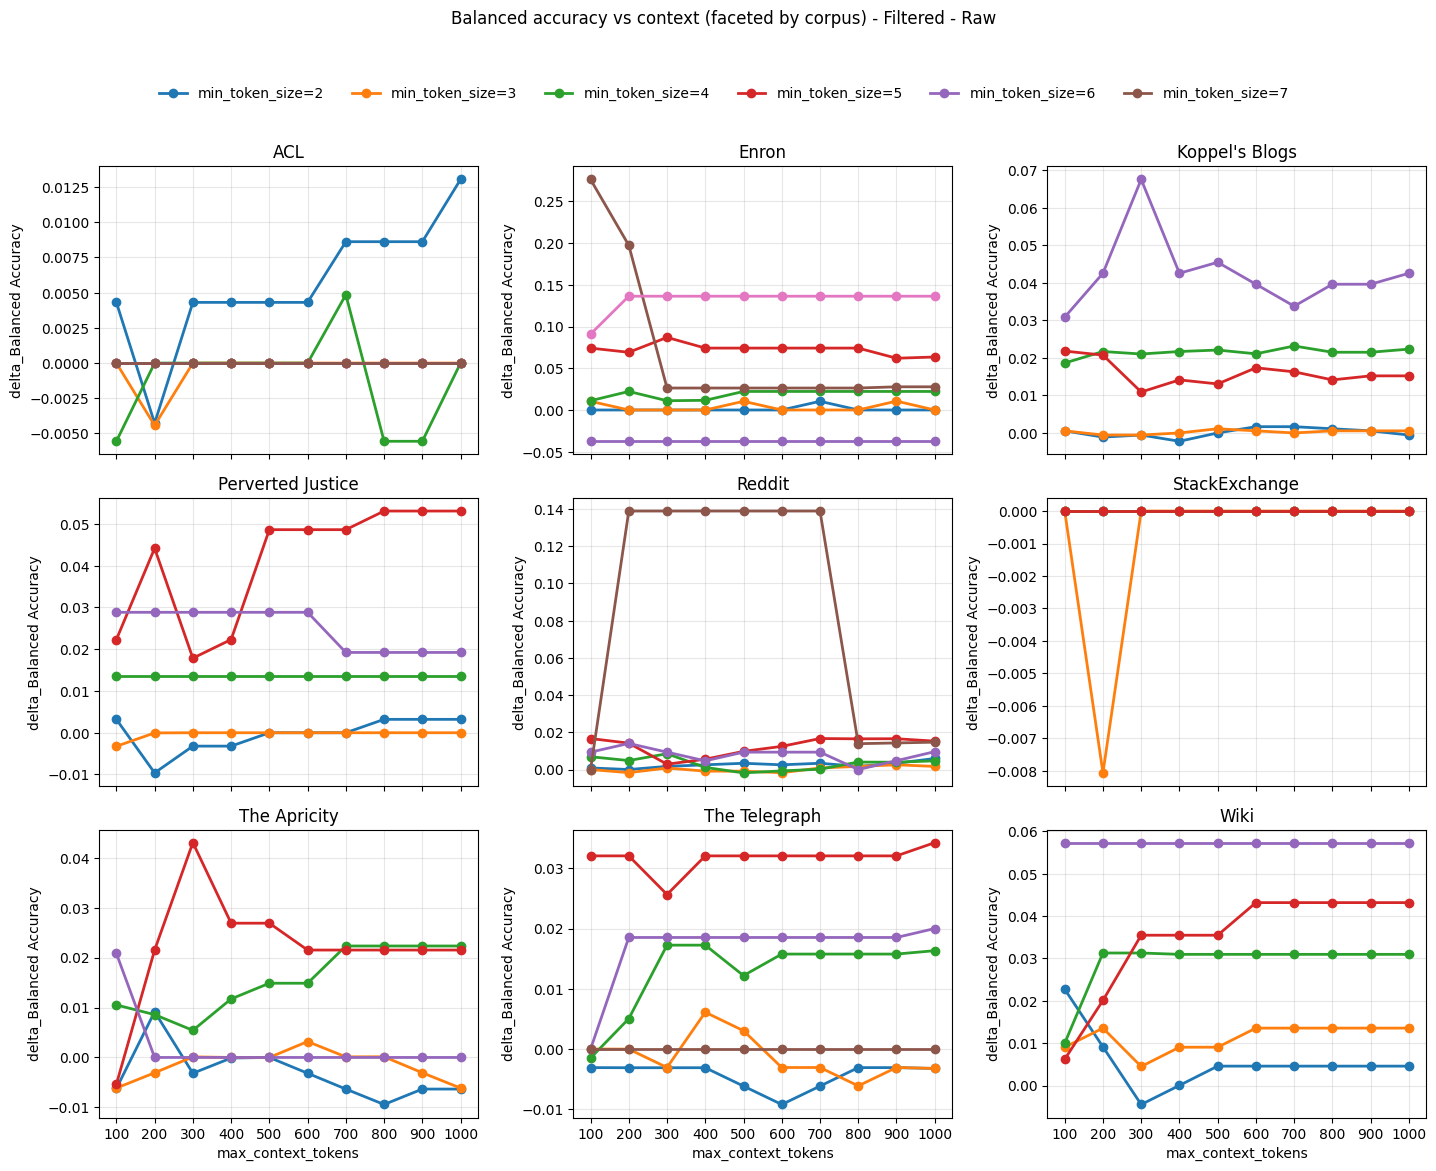

In [58]:
fig, axes = facet_balacc_vs_context_by_corpus(delta_df[~delta_df['max_context_tokens'].isna()],
                                              ncols=3,
                                              agg_fn="mean",
                                              y_col="delta_Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus) - Filtered - Raw",
                                              sharey=False)
plt.show()

# Compare Baselines

In [40]:
corpora = calibrated_df['corpus'].drop_duplicates().tolist()

In [42]:
n_gram_df = read_rds('/Volumes/BCross/av_datasets_experiments/Baseline Results/n_gram_tracing_calibrated_performance.rds')
n_gram_df = n_gram_df[n_gram_df['corpus'].isin(corpora)]

lambdag_df = read_rds('/Volumes/BCross/av_datasets_experiments/Baseline Results/lambdag_calibrated_performance.rds')

n_gram_df_filtered = (
    n_gram_df[
        (n_gram_df["coefficient"] == "simpson") &
        (n_gram_df["n"].isin([2, 3]))
    ]
    .drop(columns=["coefficient"])
)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def _order_max_context_cats(cats):
    """Sort like: 100, 200, ... (numeric ascending), then non-numeric, with None last."""
    def key(x):
        x = str(x)
        if x.lower() == "none":
            return (2, float("inf"))
        try:
            return (0, int(x))
        except ValueError:
            return (1, x)
    return sorted(pd.unique([str(c) for c in cats]), key=key)

def facet_balacc_vs_context_by_corpus_with_baselines(
    df,
    lambdag_df=None,
    n_gram_df=None,
    *,
    x_col="max_context_tokens",
    y_col="balanced_accuracy",
    facet_col="corpus",
    group_col="min_token_size",
    agg_fn="mean",
    ncols=3,
    sharey=True,
    title=None,
    legend=True,
    # lambdaG controls
    lambdag_join_col=None,          # defaults to facet_col
    lambdag_y_col=None,             # defaults to y_col
    lambdag_label="lambdaG",
    # n-gram controls
    ngram_join_col=None,            # defaults to facet_col
    ngram_n_col="n",
    ngram_score_col=None,           # defaults to y_col
    n_values=(2, 3),
    ngram_prefix="n_gram_",
):
    """
    Facet wrap by corpus (one subplot per corpus).
    X: max_context_tokens (as categorical: "None", "100", "200", ...)
    Y: y_col
    Lines: group_col

    Optionally adds baseline horizontal lines:
      - lambdaG: per-corpus scalar (label = lambdag_label)
      - n-gram: per-corpus scalars for each n in n_values (labels = f"{ngram_prefix}{n}")

    If lambdag_df is None, lambdaG line is skipped.
    If n_gram_df is None, n-gram lines are skipped.
    """
    d = df.copy()

    lambdag_join_col = facet_col if lambdag_join_col is None else lambdag_join_col
    ngram_join_col = facet_col if ngram_join_col is None else ngram_join_col
    lambdag_y_col = y_col if lambdag_y_col is None else lambdag_y_col
    ngram_score_col = y_col if ngram_score_col is None else ngram_score_col

    # ---- x categorical labels ----
    if x_col not in d.columns:
        raise ValueError(f"Missing '{x_col}' in df.")
    d["max_context_tokens_cat"] = d[x_col].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # ---- required cols ----
    for col in [y_col, facet_col, group_col]:
        if col not in d.columns:
            raise ValueError(f"Missing '{col}' in df.")

    # ---- baseline maps (corpus -> value) ----
    baseline_maps = {}  # col_name -> {corpus: value}

    # lambdaG: slim -> (corpus, lambdag)
    if lambdag_df is not None:
        if lambdag_join_col not in lambdag_df.columns:
            raise ValueError(f"Missing '{lambdag_join_col}' in lambdag_df.")
        if lambdag_y_col not in lambdag_df.columns:
            raise ValueError(f"Missing '{lambdag_y_col}' in lambdag_df.")

        lambdag_slim = (
            lambdag_df[[lambdag_join_col, lambdag_y_col]]
            .rename(columns={lambdag_join_col: facet_col, lambdag_y_col: "lambdag"})
            .groupby(facet_col, dropna=False, as_index=False)["lambdag"]
            .mean()
        )

        # merge so values exist alongside df if you want to inspect later
        d = d.merge(lambdag_slim, on=facet_col, how="left")

        baseline_maps["lambdag"] = (
            lambdag_slim.dropna(subset=["lambdag"])
            .drop_duplicates(subset=[facet_col])
            .set_index(facet_col)["lambdag"]
            .to_dict()
        )
    else:
        baseline_maps["lambdag"] = {}

    # n-gram: slim -> pivot wide -> (corpus, n_gram_2, n_gram_3, ...)
    ngram_cols = []
    if n_gram_df is not None:
        for req in [ngram_join_col, ngram_n_col, ngram_score_col]:
            if req not in n_gram_df.columns:
                raise ValueError(f"Missing '{req}' in n_gram_df.")

        ngram_slim = (
            n_gram_df[[ngram_join_col, ngram_n_col, ngram_score_col]]
            .rename(columns={ngram_join_col: facet_col, ngram_n_col: "n", ngram_score_col: "score"})
            .loc[lambda x: x["n"].isin(list(n_values))]
            .groupby([facet_col, "n"], dropna=False, as_index=False)["score"]
            .mean()
        )

        # ensure requested columns exist even if one n is missing entirely
        ngram_wide = (
            ngram_slim
            .pivot(index=facet_col, columns="n", values="score")
            .reset_index()
        )
        rename_map = {}
        for nn in n_values:
            if nn in ngram_wide.columns:
                newc = f"{ngram_prefix}{int(nn)}"
                rename_map[nn] = newc
                ngram_cols.append(newc)
            else:
                # create missing requested column as all-NaN
                newc = f"{ngram_prefix}{int(nn)}"
                ngram_wide[newc] = np.nan
                ngram_cols.append(newc)

        # columns might be ints; rename those that exist
        ngram_wide = ngram_wide.rename(columns=rename_map)

        d = d.merge(ngram_wide[[facet_col] + ngram_cols], on=facet_col, how="left")

        for col in ngram_cols:
            baseline_maps[col] = (
                ngram_wide[[facet_col, col]]
                .dropna(subset=[col])
                .drop_duplicates(subset=[facet_col])
                .set_index(facet_col)[col]
                .to_dict()
            )
    else:
        for nn in n_values:
            col = f"{ngram_prefix}{int(nn)}"
            ngram_cols.append(col)
            baseline_maps[col] = {}

    # ---- aggregate main series for plotting ----
    grp = d.groupby([facet_col, group_col, "max_context_tokens_cat"], dropna=False)[y_col]
    if agg_fn == "mean":
        plot_df = grp.mean().reset_index()
    elif agg_fn == "median":
        plot_df = grp.median().reset_index()
    else:
        raise ValueError("agg_fn must be 'mean' or 'median'")

    # ---- global ordered x ----
    x_order = _order_max_context_cats(plot_df["max_context_tokens_cat"])
    x_pos = np.arange(len(x_order))
    x_index = {lab: i for i, lab in enumerate(x_order)}

    # ---- facets ----
    facet_vals = sorted(plot_df[facet_col].dropna().unique())
    n = len(facet_vals)
    nrows = ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.8 * ncols, 3.6 * nrows),
        sharex=True,
        sharey=sharey,
    )
    axes = np.array(axes).reshape(-1)

    for i, fac in enumerate(facet_vals):
        ax = axes[i]
        sub_fac = plot_df[plot_df[facet_col] == fac]

        # main grouped lines
        for g in sorted(sub_fac[group_col].dropna().unique()):
            sub_g = sub_fac[sub_fac[group_col] == g]

            y = np.full(len(x_order), np.nan, dtype=float)
            for _, r in sub_g.iterrows():
                y[x_index[r["max_context_tokens_cat"]]] = float(r[y_col])

            ax.plot(x_pos, y, marker="o", linewidth=2, label=f"{group_col}={g}")

        # baseline horizontal lines
        if fac in baseline_maps.get("lambdag", {}):
            ax.axhline(
                float(baseline_maps["lambdag"][fac]),
                linestyle="--",
                linewidth=2,
                label=lambdag_label,
            )

        for nn in n_values:
            col = f"{ngram_prefix}{int(nn)}"
            if fac in baseline_maps.get(col, {}):
                ls = ":" if int(nn) == int(n_values[0]) else "-."
                ax.axhline(
                    float(baseline_maps[col][fac]),
                    linestyle=ls,
                    linewidth=2,
                    label=col,
                )

        ax.set_title(str(fac))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(y_col)

    # turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # x ticks/labels
    for ax in axes[:n]:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_order)

    # x label only on bottom row
    for ax in axes[(nrows - 1) * ncols : nrows * ncols]:
        if ax.has_data():
            ax.set_xlabel("max_context_tokens")

    # shared legend (unique entries across all subplots)
    if legend:
        handles, labels = [], []
        for ax in axes[:n]:
            h, l = ax.get_legend_handles_labels()
            for hh, ll in zip(h, l):
                if ll not in labels:
                    handles.append(hh)
                    labels.append(ll)

        if handles:
            fig.legend(
                handles,
                labels,
                loc="upper center",
                bbox_to_anchor=(0.5, 1.02),
                ncol=min(len(labels), 6),
                frameon=False,
            )

    if title:
        fig.suptitle(title, y=1.08 if legend else 1.02)

    plt.tight_layout()
    return fig, axes[:n]

<positron-console-cell-60>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


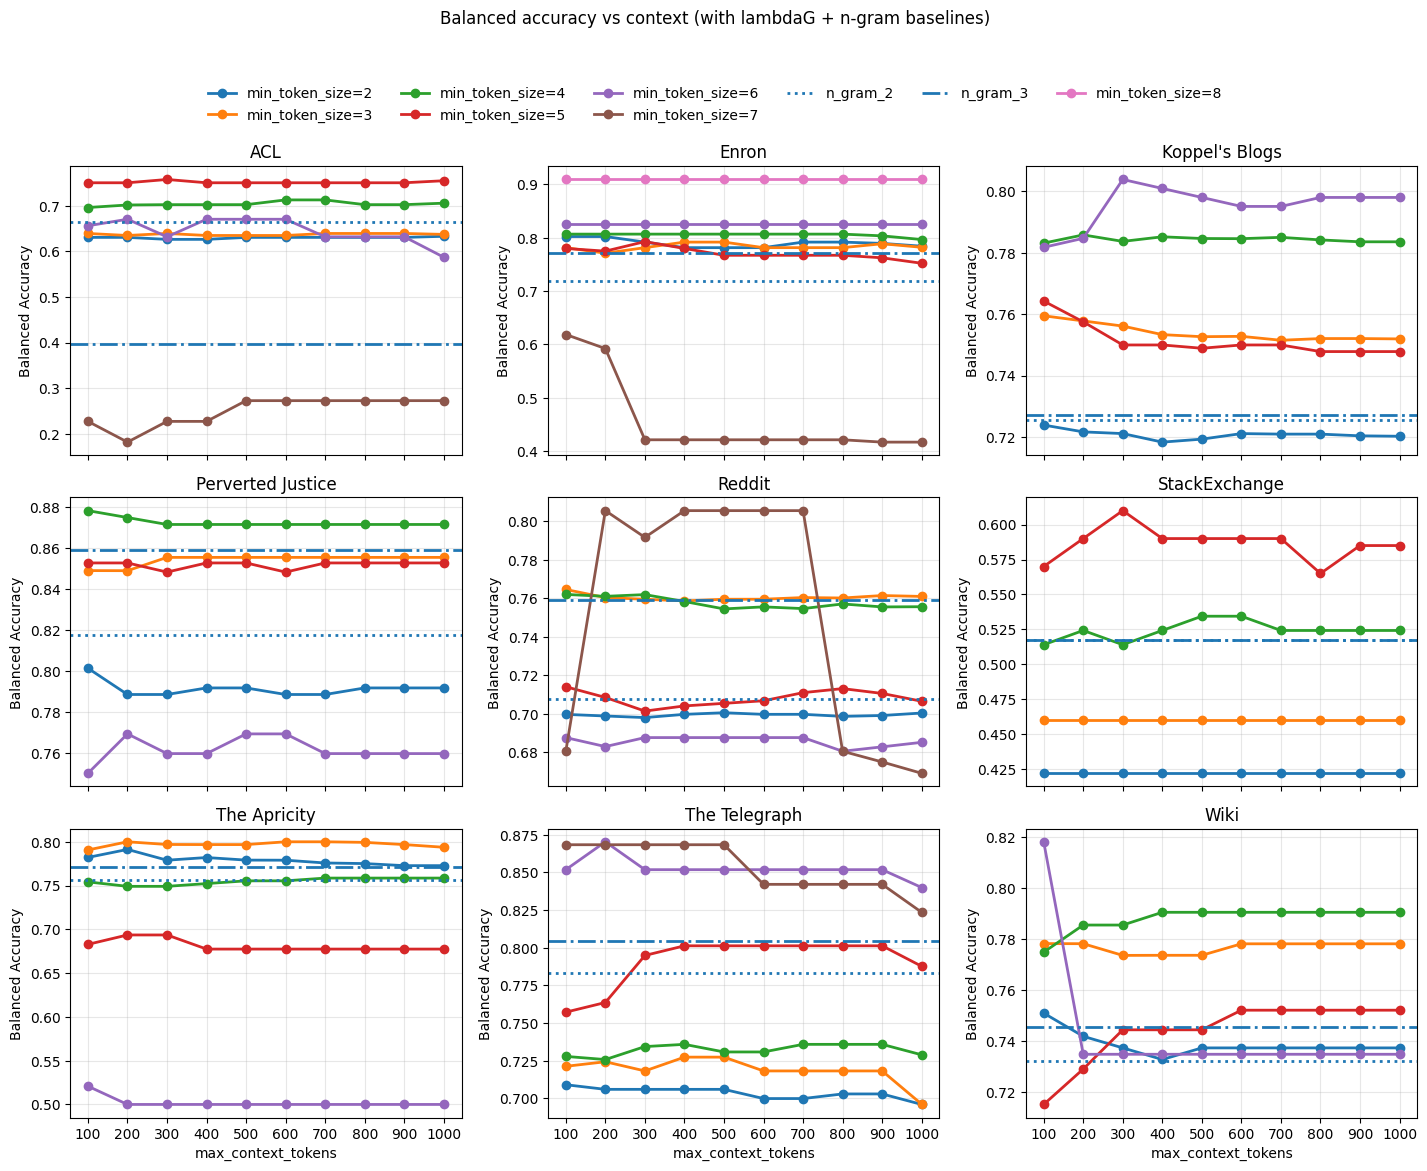

In [60]:
fig, axes = facet_balacc_vs_context_by_corpus_with_baselines(
    df=calibrated_df[(~calibrated_df['max_context_tokens'].isna())],
    lambdag_df=None,
    n_gram_df=n_gram_df_filtered,
    y_col="Balanced Accuracy",
    ncols=3,
    title="Balanced accuracy vs context (with lambdaG + n-gram baselines)",
    sharey=False
)
plt.show()

<positron-console-cell-96>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


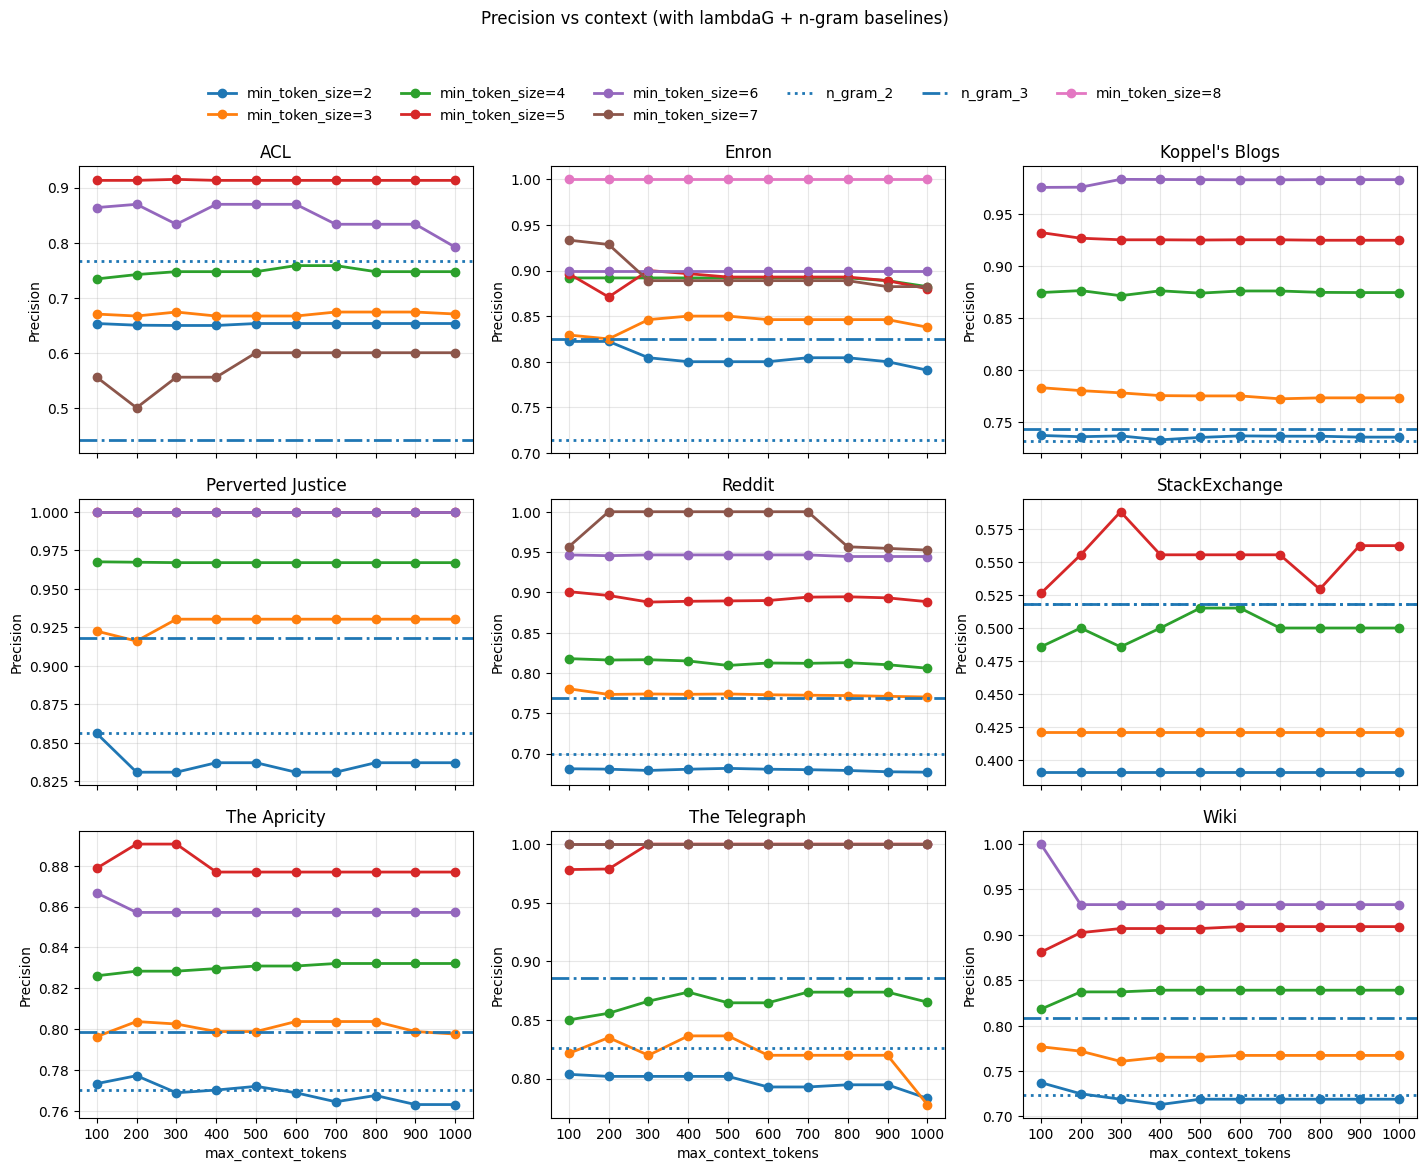

In [96]:
fig, axes = facet_balacc_vs_context_by_corpus_with_baselines(
    df=calibrated_df[(~calibrated_df['max_context_tokens'].isna())],
    lambdag_df=None,
    n_gram_df=n_gram_df_filtered,
    y_col="Precision",
    ncols=3,
    title="Precision vs context (with lambdaG + n-gram baselines)",
    sharey=False
)
plt.show()

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil


def _pick_metric_cols(df, metrics):
    """Map canonical metric names to actual df columns (case-insensitive + common variants)."""
    col_lut = {c.lower(): c for c in df.columns}

    mapping = {}
    for m in metrics:
        if m.lower() in col_lut:
            mapping[m] = col_lut[m.lower()]
            continue

        variants = {
            "balanced_accuracy": ["balanced accuracy", "bal_acc", "balacc", "balancedaccuracy"],
            "auc": ["roc_auc", "roc auc"],
            "f1": ["f1_score", "f1 score"],
            "precision": ["prec"],
            "recall": ["rec"],
        }
        found = None
        for v in variants.get(m, []):
            if v.lower() in col_lut:
                found = col_lut[v.lower()]
                break
        if found is None:
            raise ValueError(f"Missing metric '{m}' (or common variants) in df columns.")
        mapping[m] = found

    return mapping


def _aggregate_median(df, group_cols, metrics):
    """
    Median across all rows within each group (group_cols).
    Returns a df indexed by group_cols with columns = canonical metrics.
    """
    if df is None:
        return None

    for c in group_cols:
        if c not in df.columns:
            raise ValueError(f"Missing '{c}' in dataframe.")

    col_map = _pick_metric_cols(df, metrics)
    use_cols = list(group_cols) + [col_map[m] for m in metrics]
    slim = df[use_cols].copy()

    for m in metrics:
        slim[col_map[m]] = pd.to_numeric(slim[col_map[m]], errors="coerce")

    agg = (
        slim.groupby(list(group_cols), dropna=False)[[col_map[m] for m in metrics]]
        .median()
        .rename(columns={col_map[m]: m for m in metrics})
    )
    return agg


def _slim_no_aggregate(df, *, corpus_col, metrics, id_cols=()):
    """
    Keep rows as-is (no aggregation). Returns a dataframe with:
      [corpus_col] + list(id_cols present) + canonical metrics
    Drops exact duplicate rows on (corpus_col + id_cols) keeping first.
    """
    if df is None:
        return None

    if corpus_col not in df.columns:
        raise ValueError(f"Missing '{corpus_col}' in dataframe.")

    col_map = _pick_metric_cols(df, metrics)

    id_cols_present = [c for c in id_cols if c in df.columns]
    use_cols = [corpus_col] + id_cols_present + [col_map[m] for m in metrics]
    out = df[use_cols].copy()

    for m in metrics:
        out[col_map[m]] = pd.to_numeric(out[col_map[m]], errors="coerce")

    out = out.rename(columns={col_map[m]: m for m in metrics})

    # keep unique series per corpus/id combo (not aggregation; just de-dupe)
    out = out.drop_duplicates(subset=[corpus_col] + id_cols_present, keep="first").reset_index(drop=True)

    return out, id_cols_present


def facet_radar_metrics_by_corpus_and_mintok(
    df,
    lambdag_df=None,
    n_gram_df=None,
    *,
    corpus_col="corpus",
    min_token_col="min_token_size",
    metrics=("balanced_accuracy", "auc", "f1", "precision", "recall"),
    metric_labels=("Balanced Accuracy", "AUC", "F1", "Precision", "Recall"),
    labels=("df", "lambdaG", "n_gram"),
    # which extra columns (if present) to use to distinguish multiple rows per corpus
    lambdag_id_cols=None,   # default: (min_token_col,) if present else ()
    ngram_id_cols=None,     # default: (min_token_col,) if present else ('n',) if present else ()
    ncols=3,
    title=None,
    legend=True,
    rmin=0.0,
    rmax=1.0,
):
    """
    Faceted radar (spider) plots:
      - One subplot per corpus.
      - df: ONE polygon per min_token_size, where polygon values are the MEDIAN
            across max_context_tokens (and any other rows) within (corpus, min_token_size).
      - lambdag_df and n_gram_df: NOT aggregated. Rows are plotted as-is per corpus.
        If they contain multiple rows per corpus, id cols (if present) are used in the legend.
    """
    if len(metrics) != len(metric_labels):
        raise ValueError("metrics and metric_labels must have the same length.")
    if len(labels) != 3:
        raise ValueError("labels must be a 3-tuple: (df_label, lambdag_label, ngram_label).")

    # ---- main df aggregated by (corpus, min_token_size) ----
    agg_main = _aggregate_median(df, (corpus_col, min_token_col), metrics)

    # ---- lambdag_df and n_gram_df: no aggregation ----
    if lambdag_id_cols is None:
        lambdag_id_cols = (min_token_col,)
    if ngram_id_cols is None:
        ngram_id_cols = (min_token_col, "n")

    lam_slim, lam_id_cols_present = _slim_no_aggregate(
        lambdag_df, corpus_col=corpus_col, metrics=metrics, id_cols=lambdag_id_cols
    ) if lambdag_df is not None else (None, [])

    ng_slim, ng_id_cols_present = _slim_no_aggregate(
        n_gram_df, corpus_col=corpus_col, metrics=metrics, id_cols=ngram_id_cols
    ) if n_gram_df is not None else (None, [])

    corpora = sorted([c for c in agg_main.index.get_level_values(corpus_col).dropna().unique()])
    n = len(corpora)
    nrows = ceil(n / ncols)

    # ---- angles (k+1) ----
    k = len(metrics)
    angles = np.linspace(0, 2 * np.pi, k, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.8 * ncols, 4.2 * nrows),
        subplot_kw=dict(polar=True),
    )
    axes = np.array(axes).reshape(-1)

    def _plot_vals(ax, vals, lab, linestyle="-"):
        vals = np.asarray(vals, dtype=float)
        if np.any(np.isnan(vals)):
            return
        vals = np.concatenate([vals, vals[:1]])  # close
        line, = ax.plot(angles, vals, linewidth=2, marker="o", label=lab, linestyle=linestyle)
        ax.fill(angles, vals, alpha=0.08, color=line.get_color())

    def _row_label(prefix, row, id_cols_present):
        if not id_cols_present:
            return prefix
        parts = [f"{c}={row[c]}" for c in id_cols_present]
        return f"{prefix} ({', '.join(parts)})"

    for i, corpus in enumerate(corpora):
        ax = axes[i]
        ax.set_title(str(corpus))
        ax.set_ylim(rmin, rmax)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(list(metric_labels))
        ax.grid(True, alpha=0.3)

        # df polygons: one per min_token_size (aggregated median)
        try:
            sub = agg_main.xs(corpus, level=corpus_col)
            min_tokens = sorted([m for m in sub.index.dropna().unique()])
        except KeyError:
            min_tokens = []

        for mt in min_tokens:
            vals = sub.loc[mt, list(metrics)].to_numpy(dtype=float)
            _plot_vals(ax, vals, lab=f"{labels[0]} ({min_token_col}={mt})", linestyle="-")

        # lambdaG polygons: plot rows as-is (no aggregation)
        if lam_slim is not None:
            lam_sub = lam_slim[lam_slim[corpus_col] == corpus]
            for _, r in lam_sub.iterrows():
                vals = r[list(metrics)].to_numpy(dtype=float)
                _plot_vals(ax, vals, lab=_row_label(labels[1], r, lam_id_cols_present), linestyle="--")

        # n-gram polygons: plot rows as-is (no aggregation)
        if ng_slim is not None:
            ng_sub = ng_slim[ng_slim[corpus_col] == corpus]
            for _, r in ng_sub.iterrows():
                vals = r[list(metrics)].to_numpy(dtype=float)
                _plot_vals(ax, vals, lab=_row_label(labels[2], r, ng_id_cols_present), linestyle="-.")

    # turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # shared legend (unique entries across all subplots)
    if legend:
        handles, labs = [], []
        for ax in axes[:n]:
            h, l = ax.get_legend_handles_labels()
            for hh, ll in zip(h, l):
                if ll not in labs:
                    handles.append(hh)
                    labs.append(ll)

        if handles:
            fig.legend(
                handles,
                labs,
                loc="upper center",
                bbox_to_anchor=(0.5, 1.02),
                ncol=min(len(labs), 6),
                frameon=False,
            )

    if title:
        fig.suptitle(title, y=1.08 if legend else 1.02)

    plt.tight_layout()
    return fig, axes[:n]


# Example:
# fig, axes = facet_radar_metrics_by_corpus_and_mintok(
#     df,
#     lambdag_df=lambdag_df,
#     n_gram_df=n_gram_df,
#     labels=("MyMethod", "lambdaG", "n-gram"),
#     title="Median (df) vs raw baselines (radar)"
# )
# plt.show()

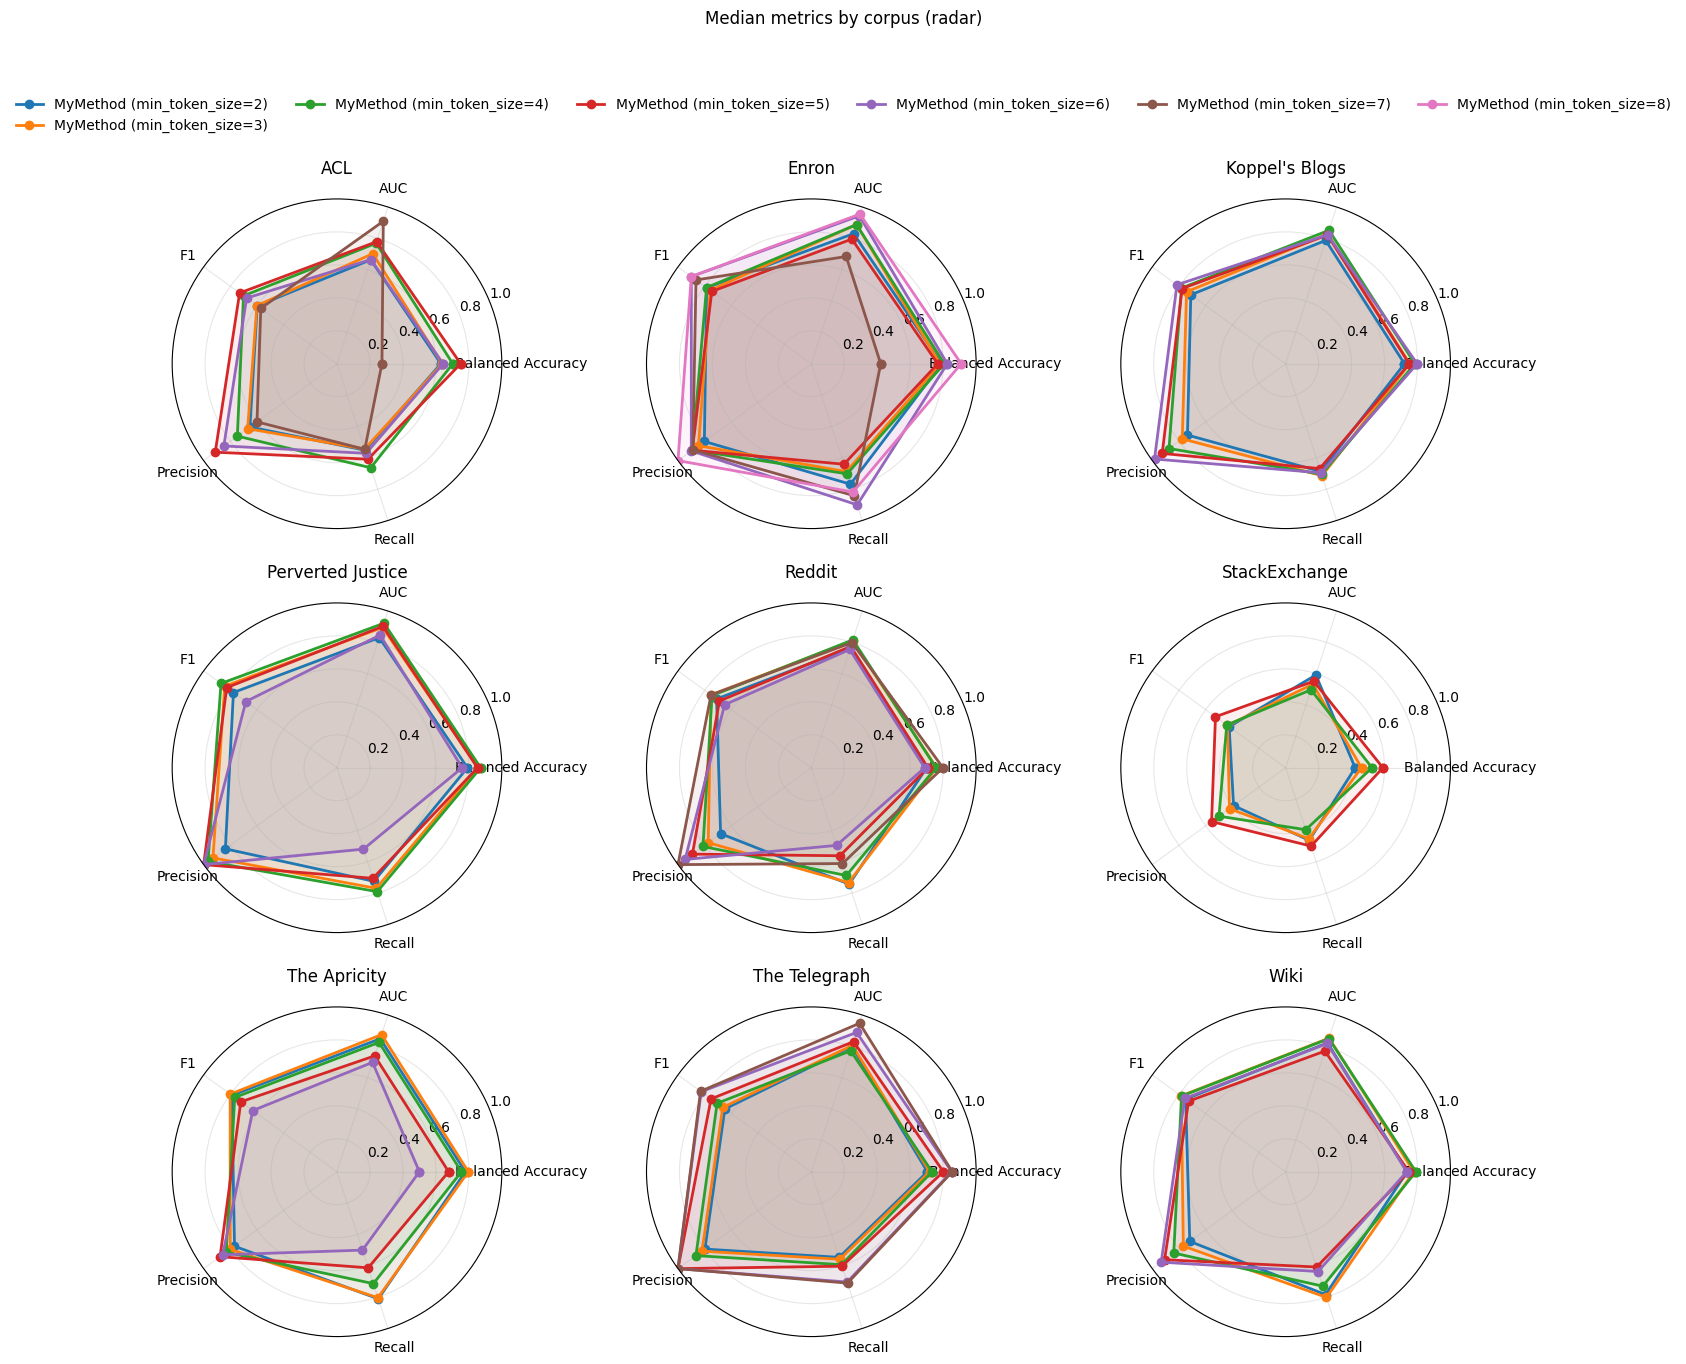

In [87]:

fig, axes = facet_radar_metrics_by_corpus_and_mintok(
    calibrated_df[
        calibrated_df["max_context_tokens"].notna()
    ],
    lambdag_df=None,
    n_gram_df=None,
    metrics=("Balanced Accuracy", "AUC", "F1", "Precision", "Recall"),
    labels=("MyMethod", "lambdaG", "n-gram"),
    title="Median metrics by corpus (radar)",
    ncols=3
)
plt.show()

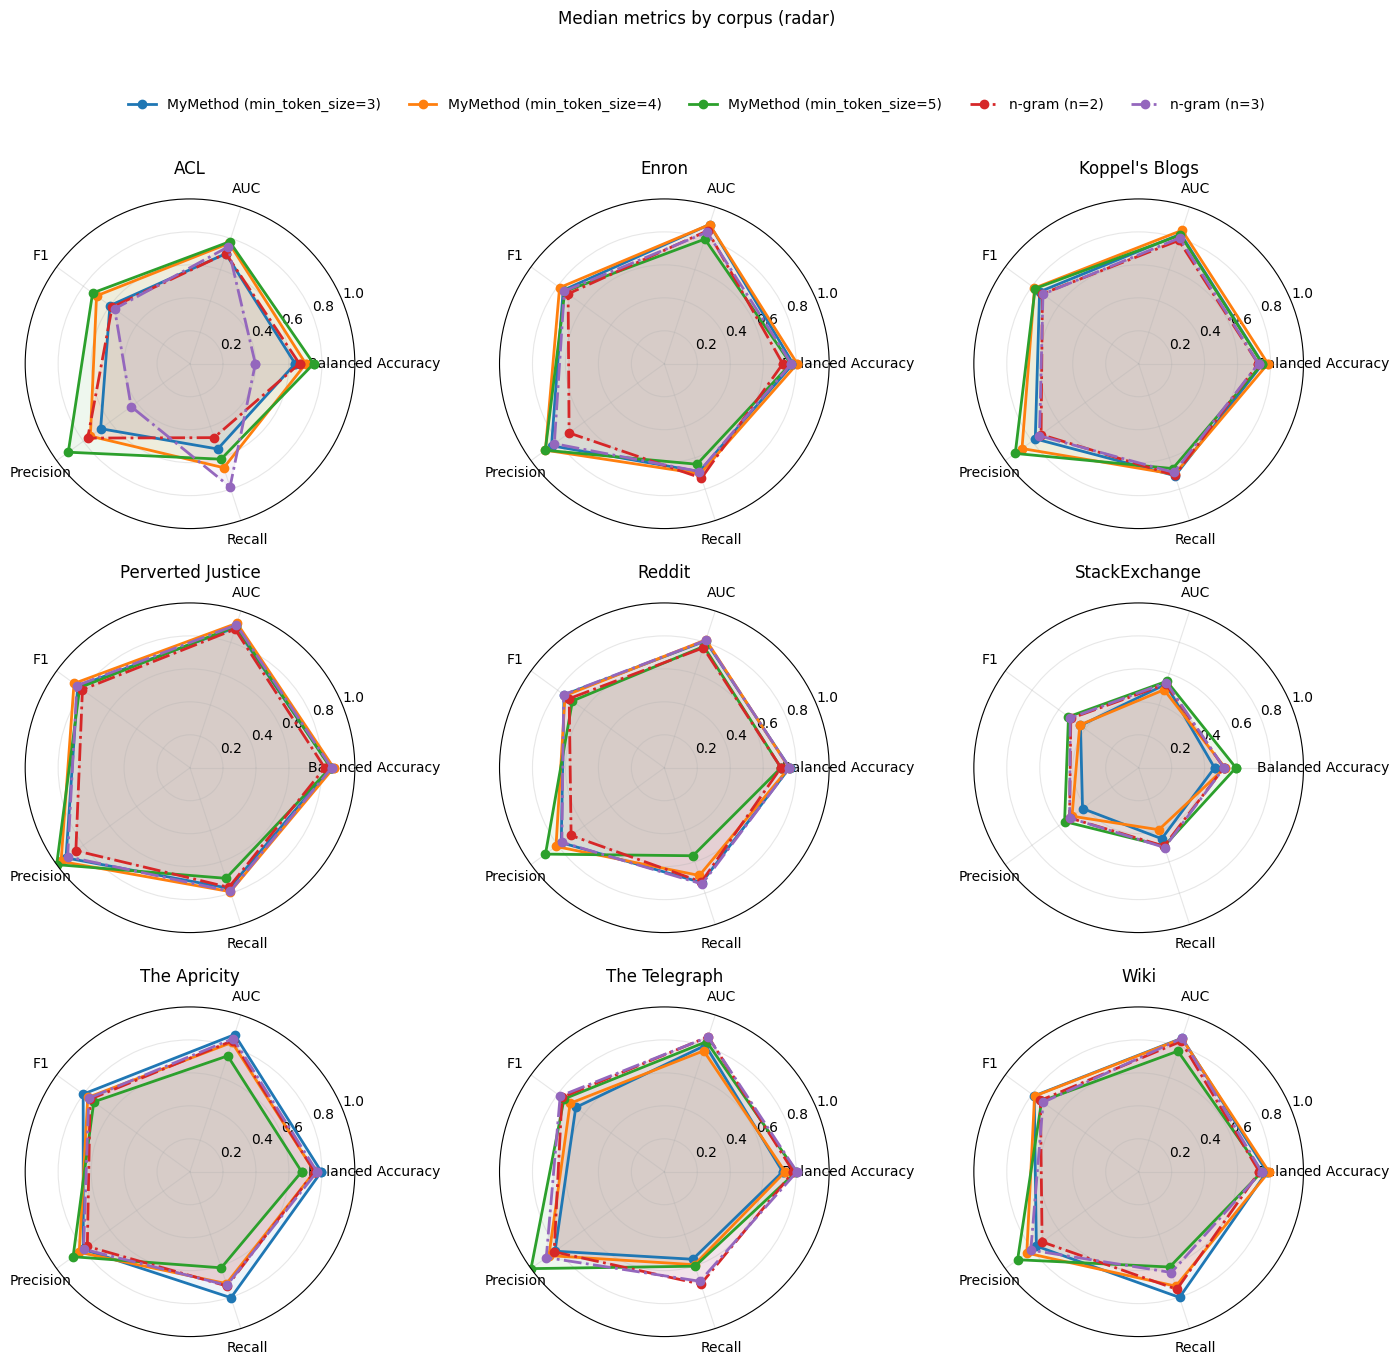

In [86]:


fig, axes = facet_radar_metrics_by_corpus_and_mintok(
    calibrated_df[
        calibrated_df["max_context_tokens"].notna()
        & calibrated_df["min_token_size"].between(3, 5, inclusive="both")
    ],
    lambdag_df=None,
    n_gram_df=n_gram_df_filtered,
    metrics=("Balanced Accuracy", "AUC", "F1", "Precision", "Recall"),
    labels=("MyMethod", "lambdaG", "n-gram"),
    title="Median metrics by corpus (radar)",
    ncols=3
)
plt.show()

## Other Metrics

<positron-console-cell-92>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


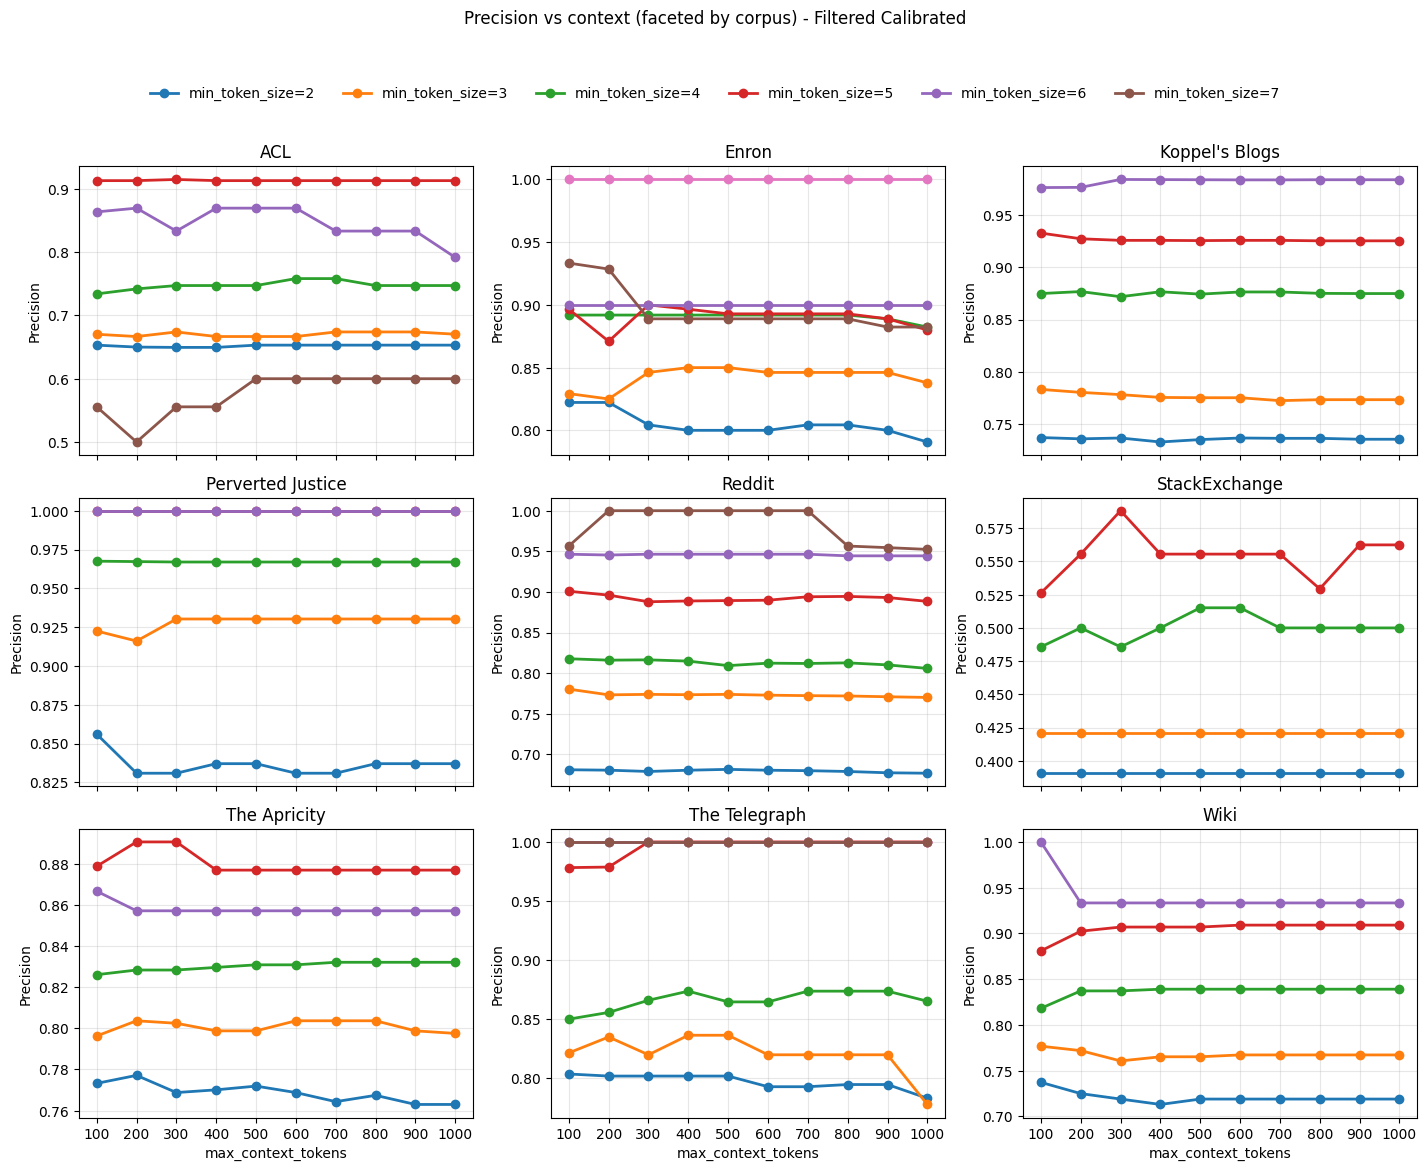

In [92]:
fig, axes = facet_balacc_vs_context_by_corpus(calibrated_df[calibrated_df['max_context_cat'] != "None"],
                                              ncols=3,
                                              agg_fn="mean",
                                              y_col="Precision",
                                              title="Precision vs context (faceted by corpus) - Filtered Calibrated",
                                              sharey=False)
plt.show()

<positron-console-cell-93>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


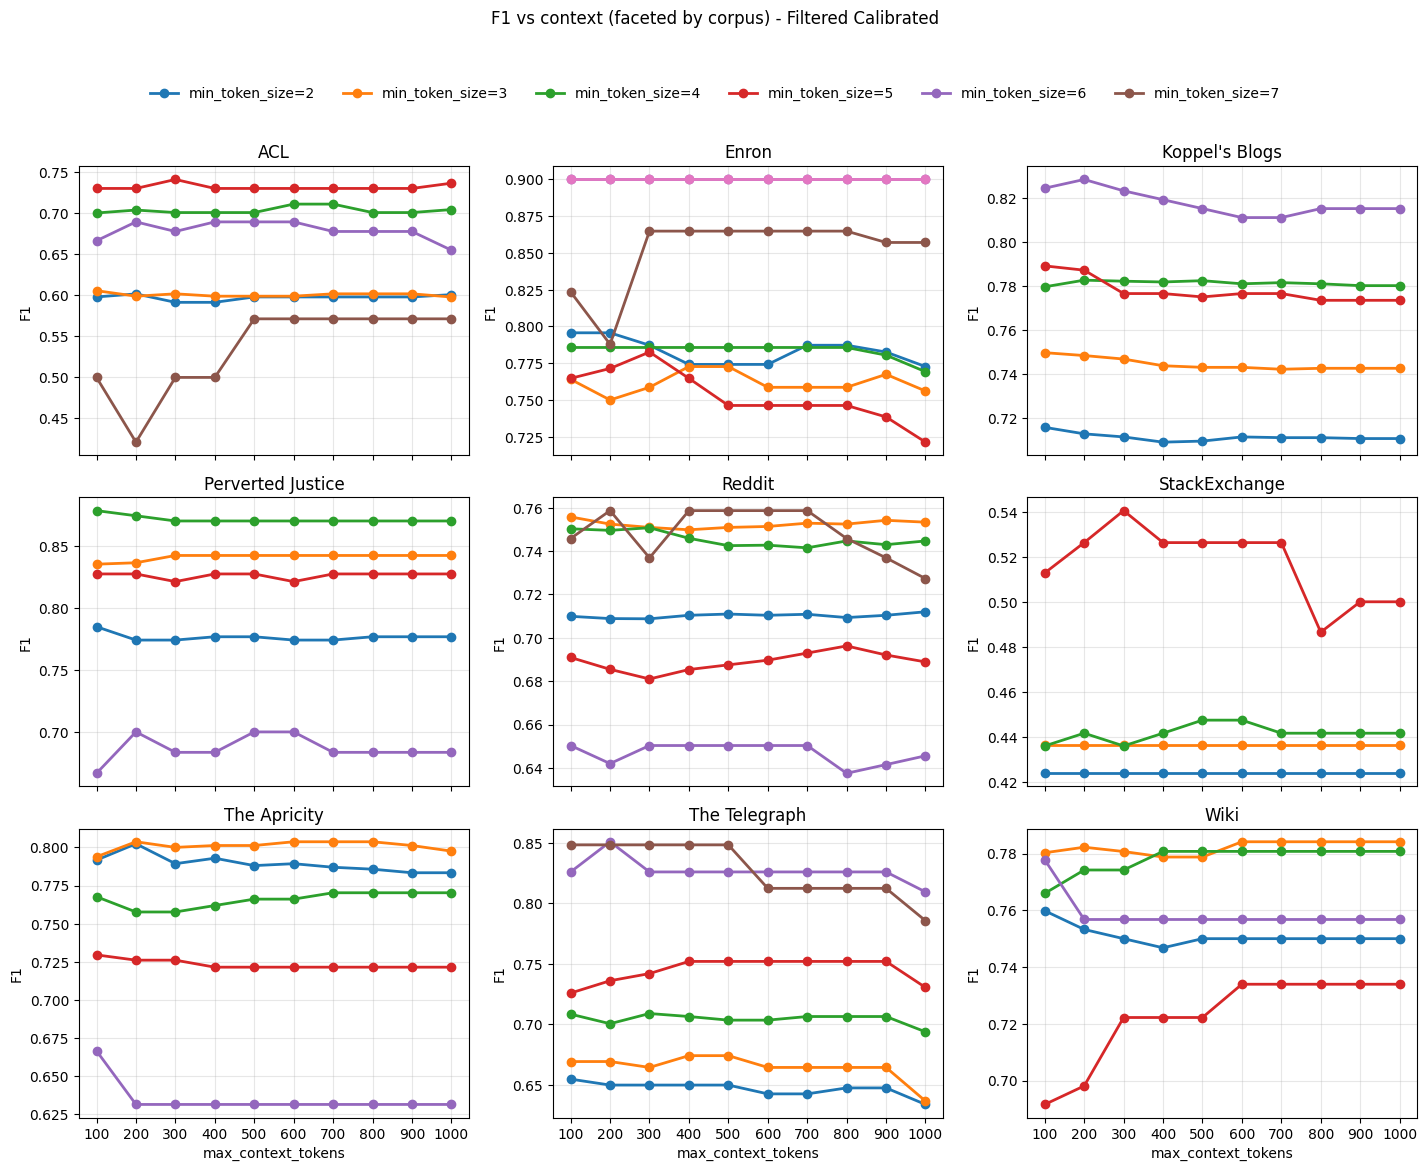

In [93]:
fig, axes = facet_balacc_vs_context_by_corpus(calibrated_df[calibrated_df['max_context_cat'] != "None"],
                                              ncols=3,
                                              agg_fn="mean",
                                              y_col="F1",
                                              title="F1 vs context (faceted by corpus) - Filtered Calibrated",
                                              sharey=False)
plt.show()

<positron-console-cell-97>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


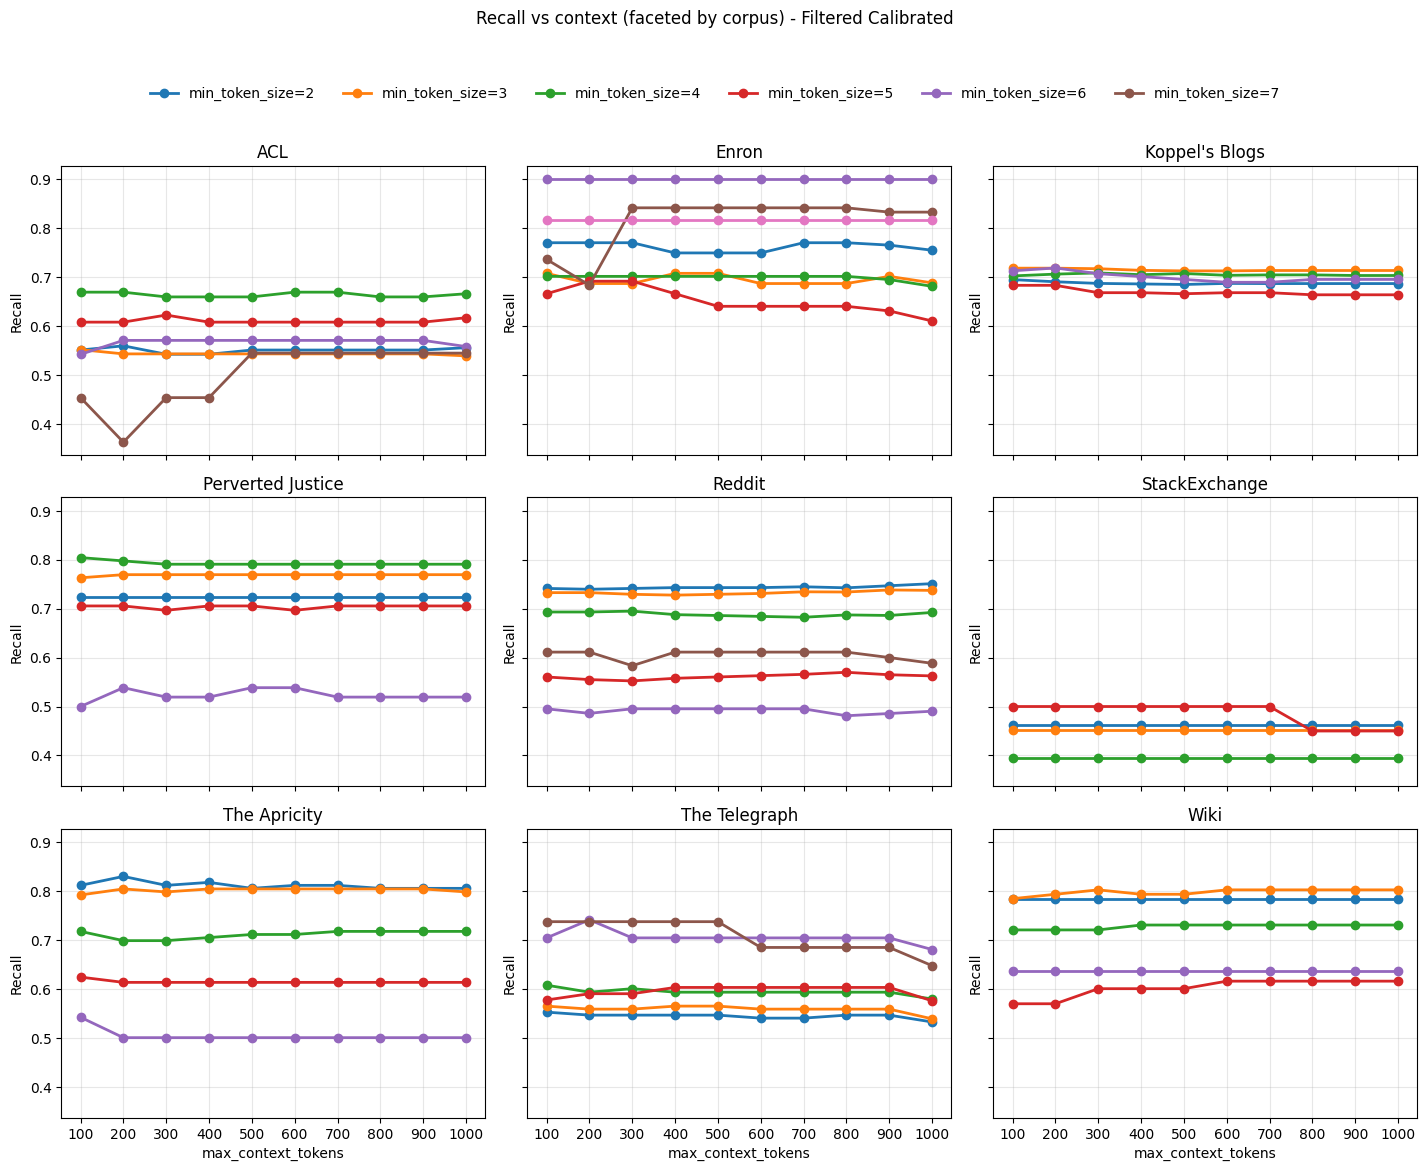

In [97]:
fig, axes = facet_balacc_vs_context_by_corpus(calibrated_df[calibrated_df['max_context_cat'] != "None"],
                                              ncols=3,
                                              agg_fn="mean",
                                              y_col="Recall",
                                              title="Recall vs context (faceted by corpus) - Filtered Calibrated",
                                              sharey=True)
plt.show()